# **🦟Malaria Cell Image Classifier With Transfer Learning**

Malaria remains a significant public health burden worldwide, and early detection plays a crucial role in saving lives.  
In this project, we build a deep learning model to automatically classify **red blood cell images** as either **infected** or **uninfected**,  
using the NIH Malaria Cell Images dataset.

# **Setup**

In [ ]:
# Core libraries
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns


# **Loading Dataset**

In [ ]:
# Load dataset from TensorFlow Datasets
data, info = tfds.load("malaria", as_supervised=True, with_info=True)
dataset = data["train"]

print("Total images:", info.splits["train"].num_examples)
print("Label names:", info.features["label"].names)

Total images: 27558
Label names: ['parasitized', 'uninfected']


The TFDS malaria dataset contains about 27,558 images labeled as:

0 = Parasitized

1 = Uninfected

There’s only a 'train' split, so we’ll manually create validation and test sets next.

# **Split Dataset**

In [ ]:
# Dataset size
total_size = info.splits["train"].num_examples
train_size = int(0.8 * total_size)
val_size   = int(0.1 * total_size)

# Shuffle and split
dataset = dataset.shuffle(total_size, seed=42)
train_data = dataset.take(train_size)
val_data   = dataset.skip(train_size).take(val_size)
test_data  = dataset.skip(train_size + val_size)

# **Preprocessing**

In [ ]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

def preprocess(image, label):
    image = tf.image.resize(image, IMG_SIZE)
    image = image / 255.0
    return image, label

train_data = train_data.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_data   = val_data.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_data  = test_data.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# **Model Building (Transfer Learning)**

In [ ]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights="imagenet"
)
base_model.trainable = False  # freeze feature extractor

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

# **Model Training**

In [ ]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=5
)

Epoch 1/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 1004s 1s/step - accuracy: 0.7638 - loss: 0.5269 - val_accuracy: 0.8987 - val_loss: 0.3112
Epoch 2/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 880s 1s/step - accuracy: 0.8894 - loss: 0.3013 - val_accuracy: 0.9071 - val_loss: 0.2605
Epoch 3/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 871s 1s/step - accuracy: 0.9106 - loss: 0.2490 - val_accuracy: 0.9154 - val_loss: 0.2251
Epoch 4/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 829s 1s/step - accuracy: 0.9201 - loss: 0.2244 - val_accuracy: 0.9136 - val_loss: 0.2266
Epoch 5/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 842s 1s/step - accuracy: 0.9264 - loss: 0.2114 - val_accuracy: 0.9263 - val_loss: 0.2067


# **Fine-Tuning**

In [ ]:
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False  # keep early layers frozen

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

fine_tune_history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=5
)

Epoch 1/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 1527s 2s/step - accuracy: 0.8605 - loss: 0.3612 - val_accuracy: 0.9416 - val_loss: 0.1616
Epoch 2/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 1422s 2s/step - accuracy: 0.9559 - loss: 0.1294 - val_accuracy: 0.9608 - val_loss: 0.1175
Epoch 3/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 1435s 2s/step - accuracy: 0.9633 - loss: 0.1075 - val_accuracy: 0.9644 - val_loss: 0.1018
Epoch 4/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 1431s 2s/step - accuracy: 0.9718 - loss: 0.0837 - val_accuracy: 0.9739 - val_loss: 0.0656
Epoch 5/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 1485s 2s/step - accuracy: 0.9754 - loss: 0.0696 - val_accuracy: 0.9833 - val_loss: 0.0525


# **Evaluation**

In [ ]:
test_loss, test_acc = model.evaluate(test_data)
print(f" Test accuracy: {test_acc:.4f}")

87/87 ━━━━━━━━━━━━━━━━━━━━ 112s 1s/step - accuracy: 0.9782 - loss: 0.0619
 Test accuracy: 0.9775


# **Classification Report and Confusion Matrix**

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 983ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 969ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 975ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 993ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 981ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 993ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 973ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/ste

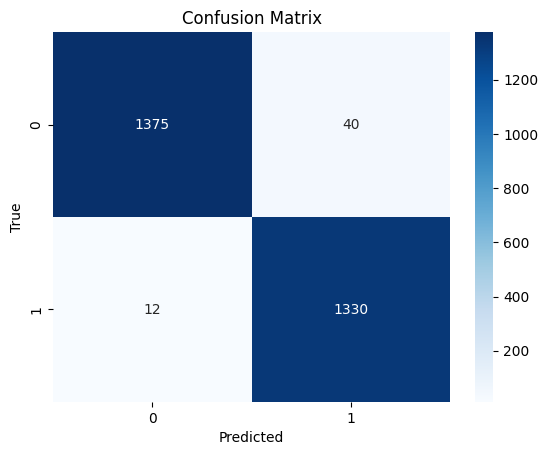

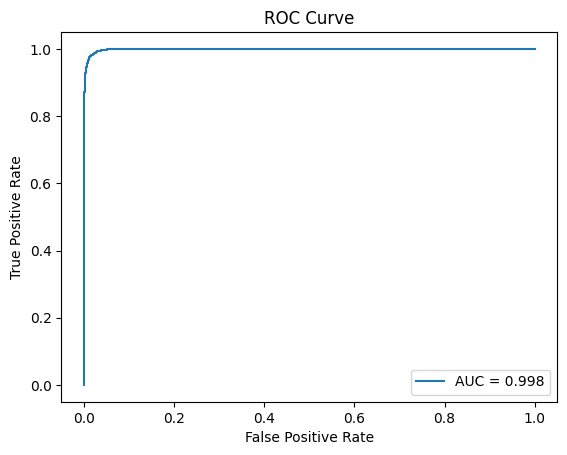

In [ ]:
# Gather true and predicted labels
y_true, y_pred, y_prob = [], [], []

for images, labels in test_data:
    probs = model.predict(images)
    preds = (probs > 0.5).astype(int).flatten()
    y_true.extend(labels.numpy())
    y_pred.extend(preds)
    y_prob.extend(probs.flatten())

print("\nClassification report:\n")
print(classification_report(y_true, y_pred))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# ROC curve
fpr, tpr, _ = roc_curve(y_true, y_prob)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_true, y_prob):.3f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.title("ROC Curve")
plt.show()

# **Save Model for Deployment**

In [ ]:
model.save("malaria_cnn_model.h5")

In [ ]:
model.save('malaria_tl_model.keras')